In [1]:
import pandas as pd
import seaborn as sns
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import cycle
import geopandas as gpd
import json
from geojson_rewind import rewind

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

## 1. Data preprocessing

In [2]:
ga_counties = gpd.read_file('/Users/mercuryliu/Documents/Covid-19 Research/Counties_Georgia.geojson')
#Populate hucs['properties'] (i.e. convert to plotly-readible geojson-type)
ga_counties = json.loads(ga_counties.to_json())
ga_counties_rewound = rewind(ga_counties,rfc7946=False)

In [3]:
ec1 = pd.read_csv('/Users/mercuryliu/Documents/Covid-19 Research/Data/Economic Data/CAINC30_GA_1969_2019.csv'
                 )
ec2 = pd.read_csv('/Users/mercuryliu/Documents/Covid-19 Research/Data/Economic Data/CAINC1_GA_1969_2019.csv'                 
)
ga_cases = pd.read_csv('/Users/mercuryliu/Documents/Covid-19 Research/Data/06252021/county_cases.csv')
ga_cases = ga_cases.drop(['State FIPS code'], axis=1)

In [4]:
ec1 = ec1[['GeoFIPS', 'GeoName', 'TableName',
    'LineCode', 'IndustryClassification', 'Description', 'Unit', '2019']]

In [5]:
p_income = ec1.loc[ec1['Description'] == 'Personal income (thousands of dollars)']

In [6]:
p_income = p_income.drop(labels=0, axis=0)

In [7]:
em_insurance = ec1.loc[ec1['Description'] == '   Employer contributions for employee pension and insurance funds 5/']
em_insurance = em_insurance.drop(labels=18, axis=0)
em_insurance = ec1.loc[ec1['Description'] == '   Employer contributions for employee pension and insurance funds 5/']


In [8]:
total_jobs = ec1.loc[ec1['Description'] == 'Total employment (number of jobs)']
total_jobs = total_jobs.drop(labels=23, axis=0)

In [9]:
#employer contribution to insurance: unit: thousands of dollars
#personal income: unit: thousands of dollars
#total jobs: unit # of jobs 
em_insurance = em_insurance.rename(columns={'GeoName': 'county_name', '2019': 'employer_contri'})
total_jobs = total_jobs.rename(columns={'GeoName': 'county_name', '2019': 'totalJobs'})
p_income = p_income.rename(columns={'GeoName': 'county_name', '2019': 'personal_income'})


In [10]:
em_insurance = em_insurance.drop(labels=18, axis=0)

In [11]:
em_insurance = em_insurance[['county_name', 'employer_contri']]
p_income = p_income[['county_name', 'personal_income']]
total_jobs = total_jobs[['county_name', 'totalJobs']]

In [12]:
em_insurance['county_name'] = em_insurance['county_name'] .replace(', GA', '', regex=True)
p_income['county_name'] = p_income['county_name'] .replace(', GA', '', regex=True)
total_jobs['county_name'] = total_jobs['county_name'] .replace(', GA', '', regex=True)

In [13]:
econ_cases = ga_cases.merge(em_insurance, how='inner', on='county_name')
econ_cases = econ_cases.merge(p_income, how='inner', on='county_name')
econ_cases = econ_cases.merge(total_jobs, how='inner', on='county_name')

In [14]:
econ_cases['incomepercapita'] = econ_cases['personal_income'] / econ_cases['population']
econ_cases['employerc_percapita'] = econ_cases['employer_contri'] / econ_cases['population']
econ_cases['jobspercapita'] = econ_cases['totalJobs'] / econ_cases['population']

In [15]:
econ_cases = econ_cases.rename(columns={'case rate': 'case_rate', 'death rate': 'death_rate'})
econ_cases['hosp_rate'] = econ_cases['hospitalization']*100000 /  econ_cases['population']

In [16]:
econ_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 0 to 158
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   county_name          159 non-null    object 
 1   cases                159 non-null    int64  
 2   county_id            159 non-null    object 
 3   County FIPS code     159 non-null    object 
 4   population           159 non-null    int64  
 5   hospitalization      159 non-null    int64  
 6   deaths               159 non-null    int64  
 7   case_rate            159 non-null    float64
 8   death_rate           159 non-null    float64
 9   14 day case rate     159 non-null    float64
 10  14 day cases         159 non-null    int64  
 11  antigen_cases        159 non-null    int64  
 12  probable_deaths      159 non-null    int64  
 13  employer_contri      159 non-null    float64
 14  personal_income      159 non-null    float64
 15  totalJobs            159 non-null    flo

In [17]:
econ_cases.head()

,county_name,cases,county_id,County FIPS code,population,hospitalization,deaths,case_rate,death_rate,14 day case rate,14 day cases,antigen_cases,probable_deaths,employer_contri,personal_income,totalJobs,incomepercapita,employerc_percapita,jobspercapita,hosp_rate
0,Appling,1925,US-13001,1,18561,189,67,10371.21,360.97,70.04,13,397,5,88012.0,652960.0,9653.0,35.179139,4.741770,0.520069,1018.264102
1,Atkinson,802,US-13003,3,8330,127,20,9627.85,240.10,12.00,1,243,3,24809.0,257538.0,3589.0,30.916927,2.978271,0.430852,1524.609844
2,Bacon,1299,US-13005,5,11404,91,29,11390.74,254.30,114.00,13,364,11,33219.0,372801.0,5408.0,32.690372,2.912925,0.474220,797.965626
3,Baker,164,US-13007,7,3116,35,10,5263.16,320.92,0.00,0,67,0,4228.0,125538.0,1043.0,40.288190,1.356868,0.334724,1123.234917
4,Baldwin,3886,US-13009,9,44428,329,118,8746.74,265.60,9.00,4,693,17,150126.0,1532017.0,22726.0,34.483141,3.379085,0.511524,740.523994


## 2. Analysis

1. Currrent research have following claims: 
-a wide range of sociodemographic risk factors, including socioeconomic status, racial/ethnic minority status, household composition, and environmental factors, were significantly associated with COVID-19 incidence and mortality.
My questions:
- Do people with lower personal income have higher Covid-19 mortality rate, or more vulnerable to serve covid-cases?
- Do people with better employer benefits have lower Covid-19 death rate, infectious rate, or hospitalization rate?
- Are there socio-economic disparities in terms of Covid-19 incidence and mortality? 

[Text(0.5, 0, 'Employer contributions to retirment and insurance fund per capita(in thousands of dollars)')]

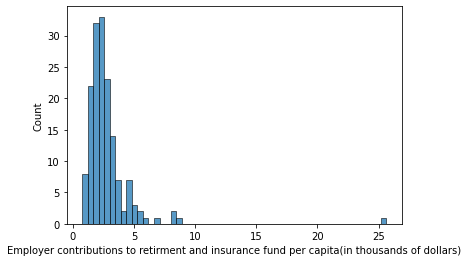

In [18]:
ax = sns.histplot(data=econ_cases, x="employerc_percapita")
ax.set(xlabel='Employer contributions to retirment and insurance fund per capita(in thousands of dollars)')

[Text(0.5, 0, 'Income per capita in 2019(in thousands of dollars)')]

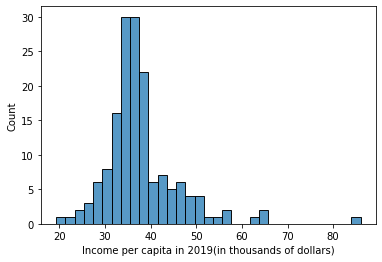

In [19]:
ax = sns.histplot(data=econ_cases, x="incomepercapita")
ax.set(xlabel='Income per capita in 2019(in thousands of dollars)')

[Text(0.5, 0, 'Jobs per capita in 2019')]

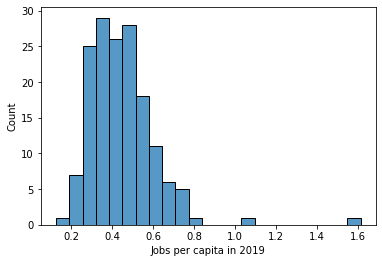

In [20]:
ax = sns.histplot(data=econ_cases, x="jobspercapita")
ax.set(xlabel='Jobs per capita in 2019')

In [21]:
def spearman(data, col1, col2):
    coefficient, pval = stats.spearmanr(data[col1], data[col2])
    return coefficient, pval
    

In [22]:
features = ['death_rate', 'case_rate', 'hosp_rate']
cof = []
cof_p = []
for i in range(3):
    a, b = spearman(econ_cases,features[i], 'incomepercapita')
    cof.append(a)
    cof_p.append(b)
pc_coef = pd.DataFrame(features, columns=['variable 1'])
pc_coef['correlation_coeffcient'] = cof
pc_coef['p-value'] = cof_p

pc_coef['variable 2'] = ['personal income per capita'] * 3

In [23]:
#correlatin with employer contributions to insurance
features = ['death_rate', 'case_rate', 'hosp_rate']
cof = []
cof_p = []
for i in range(3):
    a, b = spearman(econ_cases,features[i], 'employerc_percapita')
    cof.append(a)
    cof_p.append(b)

em_coef = pd.DataFrame(features, columns=['variable 1'])
em_coef['correlation_coeffcient'] = cof
em_coef['p-value'] = cof_p

em_coef['variable 2'] = ['employer contributions to insurance and pension per capita']*3

In [24]:
#correlatin with # of total jobs
features = ['death_rate', 'case_rate', 'hosp_rate']
cof = []
cof_p = []
for i in range(3):
    a, b = spearman(econ_cases,features[i], 'jobspercapita')
    cof.append(a)
    cof_p.append(b)

job_coef = pd.DataFrame(features, columns=['variable 1'])
job_coef['correlation_coeffcient'] = cof
job_coef['p-value'] = cof_p

job_coef['variable 2'] = ['number of jobs per capita']*3

In [25]:
corre_all = pd.concat([pc_coef, em_coef, job_coef])

In [26]:
corre_all['correlation_coeffcient']= round(corre_all['correlation_coeffcient'], 2)
corre_all['p-value']= round(corre_all['p-value'], 2)


In [27]:
corre_all = corre_all[['variable 1', 'variable 2', 'correlation_coeffcient', 'p-value']]

In [28]:
corre_all

,variable 1,variable 2,correlation_coeffcient,p-value
0,death_rate,personal income per capita,-0.15,0.07
1,case_rate,personal income per capita,0.06,0.43
2,hosp_rate,personal income per capita,0.01,0.86
0,death_rate,employer contributions to insurance and pensio...,0.08,0.34
1,case_rate,employer contributions to insurance and pensio...,0.37,0.00
2,hosp_rate,employer contributions to insurance and pensio...,0.20,0.01
0,death_rate,number of jobs per capita,0.06,0.48
1,case_rate,number of jobs per capita,0.40,0.00
2,hosp_rate,number of jobs per capita,0.23,0.00


In [29]:
corre_all = corre_all[corre_all['p-value'] <=0.05]

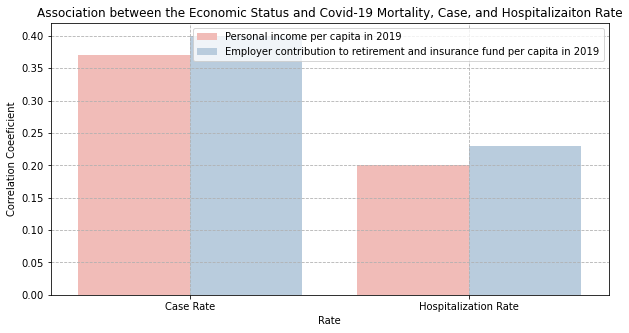

In [31]:
plt.figure(figsize=(10,5))

ax = sns.barplot(x="variable 1", y="correlation_coeffcient", hue="variable 2", data=corre_all, 
                palette='Pastel1')
ax.set_xticklabels(['Case Rate', 'Hospitalization Rate'])
ax.set(xlabel='Rate', ylabel='Correlation Coeeficient', 
       title='Association between the Economic Status and Covid-19 Mortality, Case, and Hospitalizaiton Rate')
#the following is the key to edit the legend label without losing the color 
h,l = ax.get_legend_handles_labels()
# keep same handles, edit labels with names of choice
ax.legend(handles=h, labels=['Personal income per capita in 2019', 'Employer contribution to retirement and insurance fund per capita in 2019', 
                             'Number of jobs per capita in 2019'])
plt.grid(linestyle='--')

## Conclusion
1. Covid-19 mortality rate is not associated with incomep per capita or employer contribution t to insruance and retirement fund per capita or number of jobs per capita. 
2. Covid-19 case rate is positvely correlated with income per capita. Higher income per capita indicates higher case rate. 
Covid-19 case rate is positvely correlated with employer contribution to retirement and insurance fund. This can be due to people with government or private insurance would not be hesitant to see doctors if they experience any syptoms. 
3. Covid-19 hospitalization rate is positvely correlated with income per capita. Higher income per capita indicates higher case rate. 
Covid-19 hospitalization rate is positvely correlated with employer contribution to retirement and insurance fund. Lower employer contribution to insurance does not mean that one is less vulnerable. Instead, it can be due to people with less insurance benefits may not see docotrs or seek treatment due to the high expenses of healthcare services. 
